In [1]:
import sys
import os
import pandas as pd
import datetime as datetime
import numpy as np
from dateutil.relativedelta import relativedelta
from sklearn.preprocessing import OneHotEncoder
import matplotlib
import matplotlib.pyplot as plt
#import psycopg2
from scipy.stats import ks_2samp
import scipy.stats as scats
# import visuals as vs
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from heapq import nlargest
plt.style.use('ggplot') 
%matplotlib inline

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import SimpleImputer


from icu_mortality_prediction import DATA_DIR

# MIMIC-III Critical Care Database

MIMIC-III (Medical Information Mart for Intensive Care III) is a large, freely-available database comprising deidentified health-related data associated with over forty thousand patients who stayed in critical care units of the Beth Israel Deaconess Medical Center between 2001 and 2012.

The database includes information such as demographics, vital sign measurements made at the bedside (~1 data point per hour), laboratory test results, procedures, medications, caregiver notes, imaging reports, and mortality (both in and out of hospital).

MIMIC supports a diverse range of analytic studies spanning epidemiology, clinical decision-rule improvement, and electronic tool development. It is notable for three factors:

it is freely available to researchers worldwide
it encompasses a diverse and very large population of ICU patients
it contains high temporal resolution data including lab results, electronic documentation, and bedside monitor trends and waveforms.

Citations: 
MIMIC-III, a freely accessible critical care database. Johnson AEW, Pollard TJ, Shen L, Lehman L, Feng M, Ghassemi M, Moody B, Szolovits P, Celi LA, and Mark RG. Scientific Data (2016). DOI: 10.1038/sdata.2016.35. Available at: http://www.nature.com/articles/sdata201635

Pollard, T. J. & Johnson, A. E. W. The MIMIC-III Clinical Database http://dx.doi.org/10.13026/C2XW26 (2016).



# IMPORTING LAB DATA
The mimic III database was downloaded and reconstructed locally using posgresql. The database was managed graphically using Portico. 
A query was run on the mimic III database to generate chart data for the first 24hrs of a patients icu stay as well as demographic data for patients diagnosed with sepsis according to the Angus criteria. 
(Angus et al, 2001. Epidemiology of severe sepsis in the United States; http://www.ncbi.nlm.nih.gov/pubmed/11445675 )

The query was exported from Porticoto the file LAB_EVENTS_ANGUS_FIRST24.csv. The data was read into a pandas dataframe lab_events. 


# DEBUG START

In [2]:
lab_events_raw_df = pd.read_csv(os.path.join(DATA_DIR, 'raw','D_LABITEMS.csv'))


In [3]:
lab_events_raw_df[lab_events_raw_df['LABEL']=='pH'].head()

,ROW_ID,ITEMID,LABEL,FLUID,CATEGORY,LOINC_CODE
147,21,50820,pH,Blood,Blood Gas,11558-4
158,32,50831,pH,Other Body Fluid,Blood Gas,2748-2
420,294,51094,pH,Urine,Chemistry,2756-5
690,691,51491,pH,Urine,Hematology,5803-2


# DEBUG STOP

In [4]:
lab_events_filename = 'LAB_EVENTS_FIRST24.csv'
lab_events_filepath = os.path.join(DATA_DIR, 'interim',lab_events_filename)
lab_events_data_df = pd.read_csv(lab_events_filepath) #, index_col = 'icustay_id')

lab_events_data_df.loc[:,'charttime']  = pd.to_datetime(lab_events_data_df.loc[:,'charttime'])
lab_events_data_df = lab_events_data_df.sort_values(['icustay_id', 'charttime'],ascending=True)
# lab_events_data_df.drop(['charttime'], axis=1, inplace=True)
lab_events_data_df.head()

,subject_id,icustay_id,gender,label,charttime,valuenum,flag,hospital_expire_flag
714216,55973,200001,F,Hematocrit,2181-11-25 16:16:00,26.10,abnormal,0
714217,55973,200001,F,White Blood Cells,2181-11-25 16:16:00,2.90,abnormal,0
714218,55973,200001,F,pH,2181-11-25 17:00:00,5.00,NaN,0
714219,55973,200001,F,Lactate,2181-11-25 19:27:00,1.40,NaN,0
714220,55973,200001,F,pH,2181-11-25 19:27:00,7.41,NaN,0


In [5]:
# Creates column name variables. 
lab_value = 'valuenum'
lab_label = 'label'
gender = 'gender'
label = 'label'
valuenum = 'valuenum'
hospital_expire_flag = 'hospital_expire_flag'


In [6]:
lab_events_data_df.head()

,subject_id,icustay_id,gender,label,charttime,valuenum,flag,hospital_expire_flag
714216,55973,200001,F,Hematocrit,2181-11-25 16:16:00,26.10,abnormal,0
714217,55973,200001,F,White Blood Cells,2181-11-25 16:16:00,2.90,abnormal,0
714218,55973,200001,F,pH,2181-11-25 17:00:00,5.00,NaN,0
714219,55973,200001,F,Lactate,2181-11-25 19:27:00,1.40,NaN,0
714220,55973,200001,F,pH,2181-11-25 19:27:00,7.41,NaN,0


In [7]:
# Creates copy of the lab_events_data_df dataframe for visualization exploration
aggregate_lab_values_for_visualization_df = lab_events_data_df[[gender, 
                                                             hospital_expire_flag, 
                                                            label, 
                                                            valuenum]]

In [8]:
# Generates counts for different types of lab measurements
lab_measurement_type_counts = lab_events_data_df['label'].value_counts()


lab_measurement_type_counts

pH                            218882
Hematocrit                    166293
White Blood Cells             130909
Creatinine                    130258
Glucose                       119726
Lactate                        88289
Oxygen Saturation              61903
Lactate Dehydrogenase (LD)     19261
Creatinine, Urine               7397
WBC Count                        177
24 hr Creatinine                  21
Urine Creatinine                   4
Name: label, dtype: int64

In [9]:
# Create a list of lab measurement types with counts greater than 5k. 
# Removes sparse lab values. 
lab_measurement_types = list(lab_measurement_type_counts[
                                        lab_measurement_type_counts>5000
                                                        ].index)


In [10]:
lab_measurement_types

['pH',
 'Hematocrit',
 'White Blood Cells',
 'Creatinine',
 'Glucose',
 'Lactate',
 'Oxygen Saturation',
 'Lactate Dehydrogenase (LD)',
 'Creatinine, Urine']

# Plot Distributions for All Lab Measurements By Gender and Survivor Status

In [11]:
def generate_gender_survivor_cohorts_from_raw_lab_data(lab_events_data_df, gend='F', expired=True):
    gender_survivor_cohort_df = lab_events_data_df[
                                 (lab_events_data_df[label]==lab_measurement)&             
                                 (lab_events_data_df[hospital_expire_flag]==expired)& 
                                 (lab_events_data_df[gender] == gend)
                                ]
    if gend==1:
        gender_survivor_cohort_df.name = 'Survivors'
    else:
        gender_survivor_cohort_df.name = 'Non_Survivors'
    return gender_survivor_cohort_df

In [12]:
def generate_gender_survivor_cohorts_from_processed_lab_data(processed_lab_events_data_df, gend='F', expired=True):
    gender_survivor_cohort_df = processed_lab_events_data_df[        
                                 (processed_lab_events_data_df[hospital_expire_flag]==expired)& 
                                 (processed_lab_events_data_df[gender] == gend)
                                ]
    if gend==1:
        gender_survivor_cohort_df.name = 'Survivors'
    else:
        gender_survivor_cohort_df.name = 'Non_Survivors'
    return gender_survivor_cohort_df

In [13]:
def plot_gender_survivor_lab_values_distributions(survivors, non_survivors, lab_value): 
    fig, ax = plt.subplots(figsize=(10,4))
    n, bins, patches = ax.hist(non_survivors[lab_value], 
                                                    bins=100, 
                                                    color="blue", 
                                                    alpha=0.5, 
                                                    label='Non-Survivors')
    ax2 = ax.twinx()
    
    n, bins, patches = ax2.hist(survivors[lab_value], 
                                               bins=100, 
                                               alpha=0.5, 
                                               label='Survivors'
                              )
    
    # add title, labels etc.
    plt.title('{} measurement on ICU admission'.format(lab_measurement) + 
               'vs ICU mortality by gender = {}\n'.format(gend))
    plt.xlabel(lab_measurement)
    plt.legend(loc="upper left", bbox_to_anchor=(.75,.75),fontsize=12)
    plt.show()

/Users/robertbeetel/Envs/icu_mortality_env/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/robertbeetel/Envs/icu_mortality_env/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


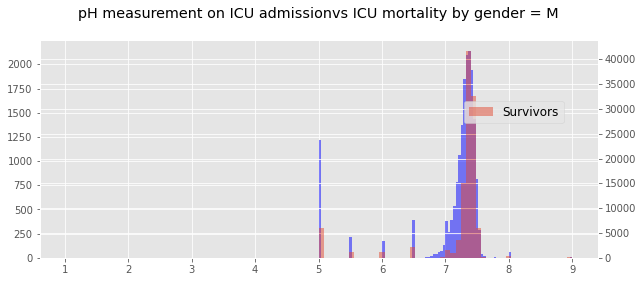

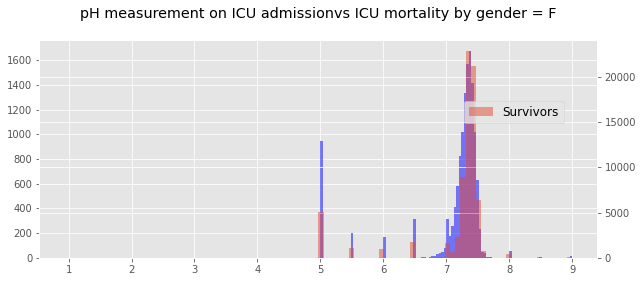

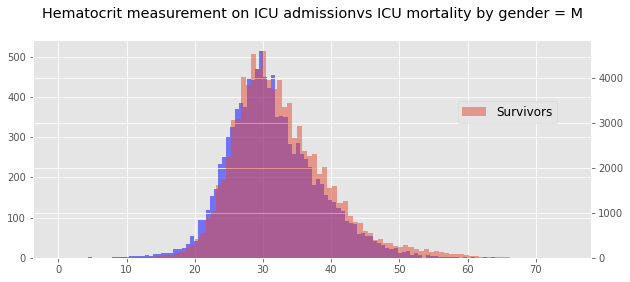

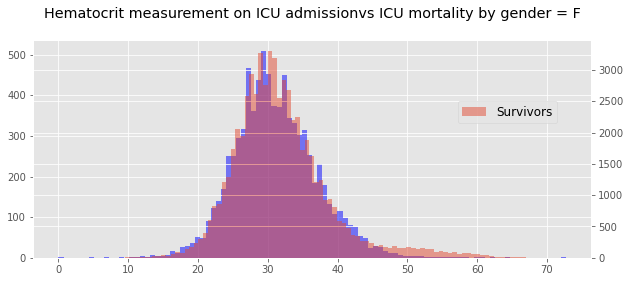

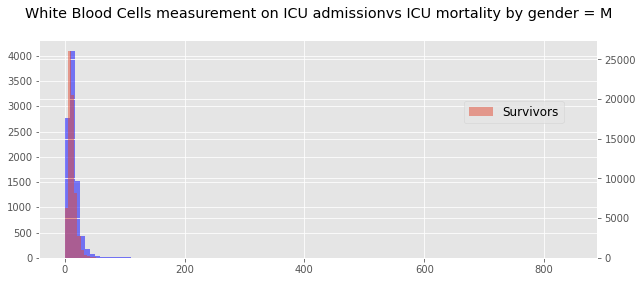

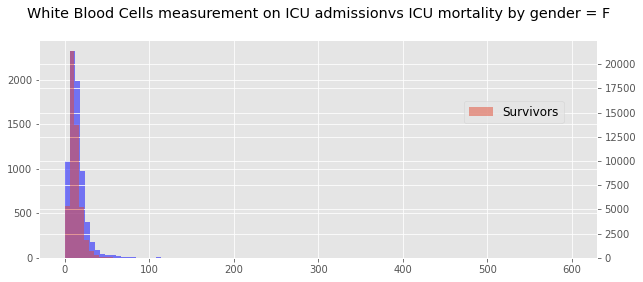

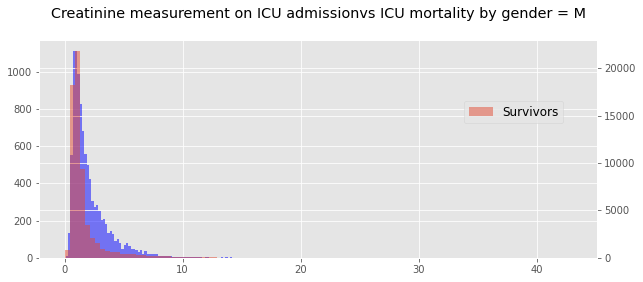

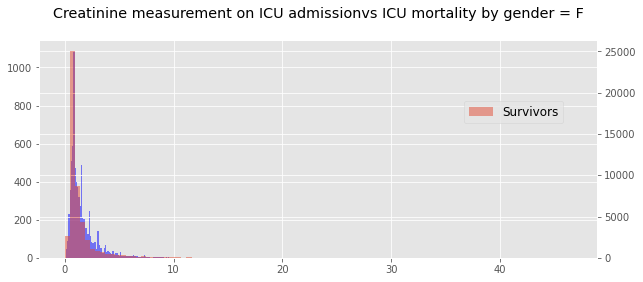

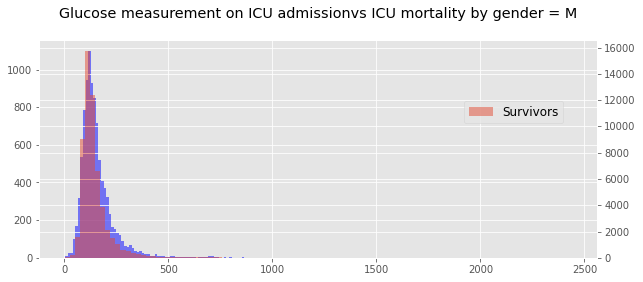

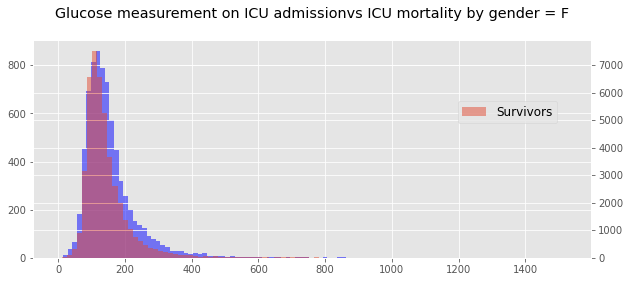

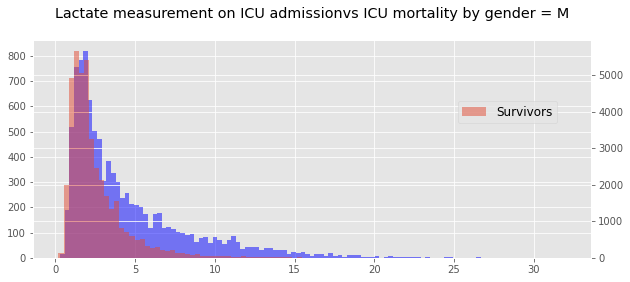

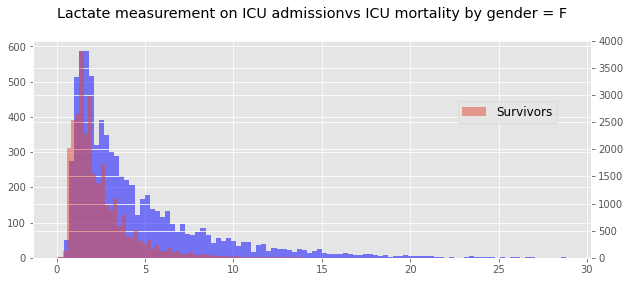

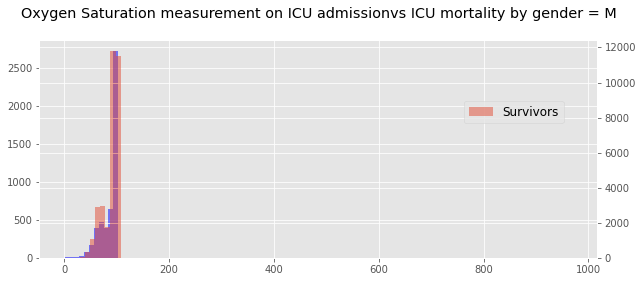

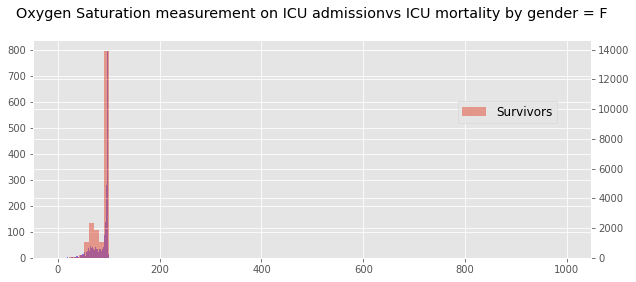

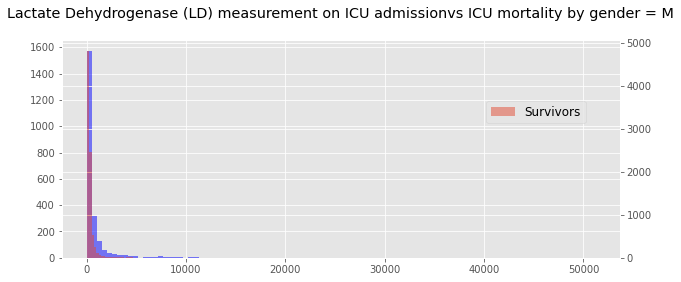

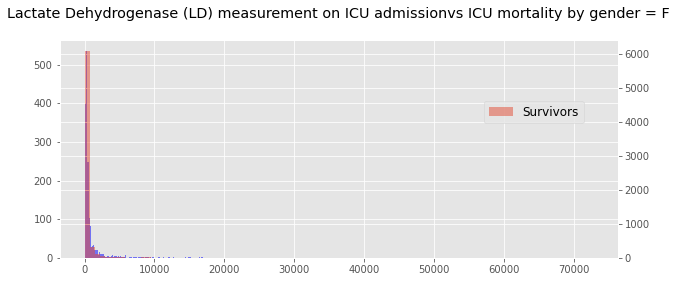

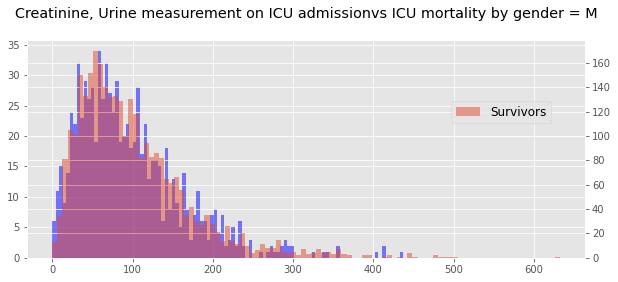

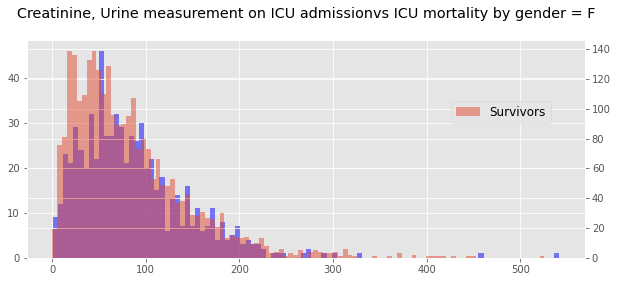

In [14]:
gender_values = ['M', 'F']

for lab_measurement in lab_measurement_types:
    for gend in gender_values:
     
        
        #print gend
        non_survivors = generate_gender_survivor_cohorts_from_raw_lab_data(lab_events_data_df, gend, expired=True)
        
        survivors = generate_gender_survivor_cohorts_from_raw_lab_data(lab_events_data_df, gend, expired=False)
        plot_gender_survivor_lab_values_distributions(survivors, non_survivors, lab_value)    

# Individual Lab Measurement Exploration

In [ ]:
def visualize_lab_value_distribution(lab_values_series, xlimits=None, bins=500):
    
    fig, axes = plt.subplots(1,2, figsize=(14,4))
    lab_values_series.plot.hist(
                            ax=axes[0],
                            bins=bins, 
                            title=lab_values_series.name + ' Distribution'
    )
    if xlimits:
        axes[0].set_xlim(xlimits)
    ax = lab_values_series.plot.hist(
                            ax=axes[1],
                            bins=bins, 
                            logx=True,
                            title=lab_values_series.name + ' Log Distribution'
    
    )
    plt.xlabel("Log Scale")
   

In [ ]:
def generate_lab_value_series(lab_values_df, lab_measurement):

    lab_values_series = lab_values_df[
                                    lab_values_df['label']== lab_measurement
                                    ]['valuenum']
    lab_values_series.name = lab_measurement
    return lab_values_series
    


In [ ]:
def generate_histogram_frequency_counts(lab_values_series, bins=1000):
    #returns non-zero frequency counts
    count, division = np.histogram(lab_values_series.dropna(), bins=bins)
    histogram_frequency_counts_series = pd.Series(count, division[:-1])
    non_zero_histogram_frequency_counts_series = histogram_frequency_counts_series[
                                                    histogram_frequency_counts_series>0
    ]
    return non_zero_histogram_frequency_counts_series

In [ ]:
def log_transform_lab_values(lab_data_df, lab_measurement):
    lab_measurement_mask = lab_data_df['label']==lab_measurement
    lab_data_df.loc[lab_measurement_mask,'valuenum'] = np.log(lab_data_df.loc[lab_measurement_mask,'valuenum'])
    return lab_data_df


In [ ]:
def remove_zero_and_negative_lab_values(lab_data_df, lab_measurement):
    lab_measurement_zero_mask = (lab_data_df['label']==lab_measurement)&(
                                lab_data_df['valuenum']<=0)
    lab_data_df.loc[lab_measurement_zero_mask, 'valuenum']=np.nan
    return lab_data_df

# pH

In [ ]:
# Visualize raw values on normal and log scale
pH_values_series = generate_lab_value_series(lab_events_data_df, 'pH')

visualize_lab_value_distribution(pH_values_series) 

### Removing values above 8 and below 6.5
Evidence to date supports the assumption that pH values outside this range are incompatible with life. 
Values outside this range also appear to occur in whole integers which leads to the conclusion that 
these are errors and not continuous measurements. 


Normal cellular metabolism and function require that blood pH be maintained within narrow limits, 
7.35-7.45. Even mild excursion outside this range has deleterious effect, 
and pH of less than 6.8 or greater than 7.8 is considered – according to medical and physiology texts – 
incompatible with life. 
Such a view is challenged by the detail of a recently published case report, 
which describes survival of a patient whose pH was just 6.53
https://acutecaretesting.org/en/journal-scans/record-breaking-blood-ph-survival-following-extreme-acidosis

In [ ]:
# filters pH value below 6.5 and above 8.0
ph_mask = (lab_events_data_df['label']=='pH')&(
            (lab_events_data_df['valuenum']<6.5)|(lab_events_data_df['valuenum']>8.0))
lab_events_data_df.loc[ph_mask,'valuenum'] = np.nan

In [ ]:
# Visualize raw values on normal and log scale
pH_values_series = generate_lab_value_series(lab_events_data_df, 'pH')

visualize_lab_value_distribution(pH_values_series) 

In [ ]:
ph_frequency_counts_series = generate_histogram_frequency_counts(pH_values_series, bins=1000)

# View frequency counts
#print(ph_frequency_counts_series.to_string())

# White Blood Cells

In [ ]:
# Visualize raw values on normal and log scale
wbc_values_series = generate_lab_value_series(lab_events_data_df, 'White Blood Cells')

visualize_lab_value_distribution(wbc_values_series) 

In [ ]:
# Visualize raw values on a predefined scale
visualize_lab_value_distribution(wbc_values_series, [0,60]) 

In [ ]:
wbc_frequency_counts_series = generate_histogram_frequency_counts(wbc_values_series, bins=1000)

# View frequency counts to see if the long tails are outliers or just very high numbers
#print(wbc_frequency_counts_series.to_string())

I am unaware of any upper possible limit on WBC counts. 
In the absence of that, the tail appears to include a number of high measurements and does not appear to result from a single 
erroneous value. Its therefore concluded there's insufficient evidence to conclude the values are outliers 


# Creatinine

In [ ]:
# Visualize raw values on normal and log scale
creatinine_values_series = generate_lab_value_series(lab_events_data_df, 'Creatinine')

visualize_lab_value_distribution(creatinine_values_series) 

### Creatinine appears to follow a log-normal distribution

In [ ]:
# Visualize raw values on a predefined scale
visualize_lab_value_distribution(creatinine_values_series, [0,13]) 

### Log transform creatinine to generate normal distribution

In [ ]:
# remove zero and negative lab values
lab_events_data_df = remove_zero_and_negative_lab_values(lab_events_data_df, 'Creatinine')

lab_events_data_df = log_transform_lab_values(lab_events_data_df, 'Creatinine')

In [ ]:
# Visualize raw values on normal and log scale
creatinine_values_series = generate_lab_value_series(lab_events_data_df, 'Creatinine')

visualize_lab_value_distribution(creatinine_values_series, bins=100) 

In [ ]:
creatinine_frequency_counts_series = generate_histogram_frequency_counts(creatinine_values_series, bins=1000)

# View frequency counts to see if the long tails are outliers or just very high numbers
#print(creatinine_frequency_counts_series.to_string())

The highest peak creatinine level observed as of 2013 was 53.9. The long tail observed here is therefore
within the range of observed values. 

https://www.researchgate.net/publication/273742614_A_Surviving_Patient_with_Record_High_Creatinine#:~:text=A%20literature%20search%20indicates%20that,in%20the%20literature%20%5B3%5D%20.


# Glucose

In [ ]:
# Visualize raw values on normal and log scale
glucose_values_series = generate_lab_value_series(lab_events_data_df, 'Glucose')

visualize_lab_value_distribution(glucose_values_series) 

In [ ]:
# Visualize raw values on a predefined scale
visualize_lab_value_distribution(glucose_values_series, [0,750]) 

### Glucose appears to follow a log-normal distribution

In [ ]:
glucose_frequency_counts_series = generate_histogram_frequency_counts(glucose_values_series, bins=1000)

# View frequency counts to see if the long tails are outliers or just very high numbers
# print(glucose_frequency_counts_series.to_string())

The highest recorded blood glucose measurement as of 2001 was 2,656. 
The long tail observed here is therefore within the range of observed values. 

Michael Patrick Buonocore (USA) (b. 19 May 2001), survived a blood sugar level of 147.6 mmol/L (2,656 mg/dl) when admitted 
to the Pocono Emergency Room in East Stroudsburg, Pennsylvania, USA, on 23 March 2008. The normal blood sugar range is 
between 4.4 to 6.6 mmol/L (80-120 mg/dl).

https://www.guinnessworldrecords.com/world-records/highest-blood-sugar-level/?fb_comment_id=811257658947726_974655159274641#:~:text=Michael%20Patrick%20Buonocore%20(USA)%20(,%2D120%20mg%2Fdl).

### Log transform glucose to generate normal distribution

In [ ]:
# remove zero and negative lab values
lab_events_data_df = remove_zero_and_negative_lab_values(lab_events_data_df, 'Glucose')

lab_events_data_df = log_transform_lab_values(lab_events_data_df, 'Glucose')

In [ ]:
# Visualize log transformed glucose values
glucose_values_series = generate_lab_value_series(lab_events_data_df, 'Glucose')

visualize_lab_value_distribution(glucose_values_series, bins=100) 

# Lactate 

In [ ]:
# Visualize raw values on normal and log scale
lactate_values_series = generate_lab_value_series(lab_events_data_df, 'Lactate')

visualize_lab_value_distribution(lactate_values_series) 

### Lactate appears to follow a log-normal distribution

### Log transform glucose to generate normal distribution

In [ ]:
# remove zero and negative lab values
lab_events_data_df = remove_zero_and_negative_lab_values(lab_events_data_df, 'Lactate')

lab_events_data_df = log_transform_lab_values(lab_events_data_df, 'Lactate')

In [ ]:
# Visualize log transformed glucose values
lactate_values_series = generate_lab_value_series(lab_events_data_df, 'Lactate')

visualize_lab_value_distribution(lactate_values_series, bins=500) 

# Oxygen Saturation

In [ ]:
# Visualize raw values on normal and log scale
oxygen_values_series = generate_lab_value_series(lab_events_data_df, 'Oxygen Saturation')

visualize_lab_value_distribution(oxygen_values_series) 

### Oxygen Saturation is a percent value and can't be above 100

In [ ]:
# filters pH value below 6.5 and above 8.0
o2_mask = (lab_events_data_df['label']=='Oxygen Saturation')&(
            lab_events_data_df['valuenum']>100)
lab_events_data_df.loc[o2_mask,'valuenum'] = np.nan

In [ ]:
# Visualize raw values on normal and log scale
oxygen_values_series = generate_lab_value_series(lab_events_data_df, 'Oxygen Saturation')

visualize_lab_value_distribution(oxygen_values_series) 

### Oxygen appears to follow a non-normal distribution and non-log normal distribution

In [ ]:
oxygen_frequency_counts_series = generate_histogram_frequency_counts(oxygen_values_series, bins=100)

# View frequency counts to see if the long tails are outliers or just very high numbers
#print(oxygen_frequency_counts_series.to_string())

### Lactate Dehydrogenase (LD)

In [ ]:
# Visualize raw values on normal and log scale
ld_values_series = generate_lab_value_series(lab_events_data_df, 'Lactate Dehydrogenase (LD)')

visualize_lab_value_distribution(ld_values_series) 

In [ ]:
# Visualize raw values on normal and log scale
ld_values_series = generate_lab_value_series(aggregate_lab_values_for_visualization_df, 
                                             'Lactate Dehydrogenase (LD)')

visualize_lab_value_distribution(ld_values_series, [0,6000], bins=10000) 

### Lactate Dehydrogenase appears to follow a Log-Normal distribution

In [ ]:
# remove zero and negative lab values
lab_events_data_df = remove_zero_and_negative_lab_values(lab_events_data_df, 
                                                         'Lactate Dehydrogenase (LD)')

lab_events_data_df = log_transform_lab_values(lab_events_data_df, 
                                              'Lactate Dehydrogenase (LD)')

In [ ]:
# Visualize raw values on normal and log scale
ld_values_series = generate_lab_value_series(lab_events_data_df, 
                                             'Lactate Dehydrogenase (LD)')

visualize_lab_value_distribution(ld_values_series) 

In [ ]:
ld_frequency_counts_series = generate_histogram_frequency_counts(ld_values_series, bins=100)

# View frequency counts to see if the long tails are outliers or just very high numbers
# print(ld_frequency_counts_series.to_string())

# Creatinine, Urine

In [ ]:
# Visualize raw values on normal and log scale
urine_creatinine_values_series = generate_lab_value_series(lab_events_data_df, 'Creatinine, Urine')

visualize_lab_value_distribution(urine_creatinine_values_series, bins=1000) 

### Urine Creatinine appears to follow a right-skewed normal distribution

In [ ]:
urine_creatinine_frequency_counts_series = generate_histogram_frequency_counts(urine_creatinine_values_series, bins=100)

# View frequency counts to see if the long tails are outliers or just very high numbers
# print(urine_creatinine_frequency_counts_series.to_string())

## Reorganizing the data
The imported data uses subject_id as the index. The following code moves the subject_id data to a column, creates
a proper index and reorganizes the columns to have the lab results grouped together. 

In [ ]:
# print("loading lab data")
# lab_events_data_df['subject_id'] = lab_events_data_df.index
# lab_events_data_df.set_index(np.arange(lab_events_data_df.shape[0]), inplace = True)
# cols = list(lab_events_data_df.columns)
# cols.insert(0, cols.pop(cols.index('icustay_id')))
# cols.insert(1, cols.pop(cols.index('subject_id')))
# lab_events_data_df = lab_events_data_df[cols]
# print("complete")

In [ ]:
lab_events_data_df.head(200)

In [ ]:
unique_icu_stay_count = lab_events_data_df.drop_duplicates('icustay_id', keep = 'first').shape[0]
unique_patients_count = lab_events_data_df.drop_duplicates('subject_id', keep = 'first').shape[0]

print("The number of unique ICU stays = {}".format(unique_icu_stay_count))
print("The number of unique patients  = {}\n".format(unique_patients_count))

# display the different measurements captured in the database query
labels = lab_events_data_df.label.unique()
print("Lab measurements inlcude/n")
print(labels)
# display(lab_events_data_df.shape)
print("Example lab values for Lactate:")
display(lab_events_data_df[(lab_events_data_df.label=='Lactate') & (~(lab_events_data_df.valuenum.isnull()))].head())



## Assessing Feature Prevalence


## CALCULATE NUMBER OF SAMPLES FOR EACH FEATURE

In [ ]:
lab_measurements = lab_measurement_types

In [ ]:
# calculating the number of samples taken in 24 hours for each measurement

lab_counts_df = None
for index, item in enumerate(lab_measurements):
    if index==0:
        lab_counts_df =  lab_events_data_df[lab_events_data_df['label'] == item][
                            ['icustay_id', 'label']].dropna().groupby('icustay_id').count()
        lab_counts_df.columns = [item]
    else:
        #num_samps = data['icustay_id'][data.label == item].dropna().unique().shape[0]
        groupby_counts = lab_events_data_df[lab_events_data_df['label'] == item][
                            ['icustay_id', 'label']].dropna().groupby('icustay_id').count()
        groupby_counts.columns = [item]
        lab_counts_df = lab_counts_df.merge(groupby_counts,left_index = True, 
                                        right_index = True, how = 'left', sort = True) 
        #print "{}    {}".format(item, num_measures) #, num_measures)

#num_samps_df.drop('label', axis=1, inplace = True)
lab_counts_df.dropna().head(20)

## GENERATE COLORMAPS SHOWING PATTERNS OF MISSING DATA 

In [ ]:
# DISPLAY COLORMAP OF MISSING SAMPLES FOR EACH VARIABLE
# REFERRING TO THIS AS AN AFFINITY MAP, SHOWING WHICH DATA WAS COLLECTED MOST OFTEN TOGETHER. 
# ASSIGNING NaN A POSITIVE VALUE MAKES MISSING DATA APPEAR BRIGHT YELLOW

lab_count_map_df = lab_counts_df.copy()

for col in lab_count_map_df.columns:
        lab_count_map_df[col] = lab_count_map_df[col].apply(lambda x: 1 if pd.isnull(x) else 0)
        

# lab_count_map_df = lab_count_map_df.sort_values(by ='Oxygen Saturation', axis = 0, ascending = True)
plt.rc('font', size=15)   
plt.figure(figsize= (25,15))
plt.pcolor(lab_count_map_df)
#ax.set_ylim([0.0,missing.shape[0]])


plt.xticks(np.arange(0.5, len(lab_count_map_df.columns), 1), lab_count_map_df.columns)
plt.xticks(rotation = 30, ha = 'right')

plt.show()
plt.close()

## Feature Engineering
Calculating values from original data including mean, std, delta etc. 


In [ ]:
lab_measurements.sort()

lab_measurements

In [ ]:
def create_lab_measurement_alias_dictionary(lab_measurements,lab_measurement_alias,calculation):
    
    lab_measurement_alias_dict = dict(zip([item + '_' + calculation for item in lab_measurements], lab_measurements))
    return lab_measurement_alias_dict

In [ ]:
# lab_measurements were sorted alphabetically so we order this list accordingly before zipping
lab_measurement_alias = ['Creat','CreatUrine', 'Gluc', 'Hemat', 'Lac', 'LacDehyd', 'O2sat', 'WBC', 'pH']

In [ ]:
first_dict_alias = create_lab_measurement_alias_dictionary(
                        lab_measurements,lab_measurement_alias, 'first')

In [ ]:
# creates a dictionary with calculations as keys and dictionaries which map the 
# name of the new, calculated feature to the original lab measurement
calc_list = ['first', 'mean', 'median', 'std', 'skew', 'min', 'max', 'slope', 'delta', 'abnflag']
alias_calculations_dict = dict(zip(calc_list, 
                                   [create_lab_measurement_alias_dictionary(
                                    lab_measurements,lab_measurement_alias,calc) for calc in calc_list]
                                  ))
calc_dict = dict(zip(calc_list, [dict() for calc in calc_list]))

In [ ]:
def abnormal_flag_calculation(x): 
    if 'abnormal' in x.values:
        flag = int(1)
    else:
        flag = int(0)
    return flag


In [ ]:
# groupby variations
# lab_events_data_df[(lab_events_data_df['icustay_id'] ==200001)&(
# #                    (lab_events_data_df.label =='pH')
# # )].dropna(subset=['valuenum'])

# lab_events_data_df[lab_events_data_df.label =='pH'].groupby('icustay_id')['valuenum'].get_group(200001)

# lab_events_data_df[lab_events_data_df.label =='pH'].groupby('icustay_id')['valuenum'].get_group(200001).values[-1:]

# dir(lab_events_data_df[lab_events_data_df.label =='pH'].groupby('icustay_id')['valuenum'])

# lab_events_data_df[lab_events_data_df.label =='pH'].groupby('icustay_id')['flag'].apply(abnormal_flag_calculation)

# lab_events_data_df[lab_events_data_df.label =='pH'].dropna(subset=['valuenum']).groupby('icustay_id')['valuenum'].get_group(200001).sort_values()

In [ ]:
# lab_events_data_df[lab_events_data_df.label =='pH'].head(200).dropna(subset=['valuenum']).groupby('icustay_id').apply(
#             lambda x: x.sort_values(["charttime"], ascending = True)).reset_index(drop=True).head(5)

In [ ]:
# lab_events_data_df[lab_events_data_df.label =='pH'].head(200).dropna(subset=['valuenum']).groupby('icustay_id').apply(
#             lambda x: x.sort_values(["charttime"], ascending = True).iloc[-1:]).reset_index(drop=True)

In [ ]:
# lab_events_data_df[lab_events_data_df.label =='pH'].head(200).groupby('icustay_id').apply(lambda x: x.sort_values(["charttime"], ascending = True).iloc[0]).reset_index(drop=True)

In [ ]:
# lab_events_data_df[lab_events_data_df.label =='pH'].head(200).groupby('icustay_id').apply(lambda x: x.sort_values(["charttime"], ascending = True))['charttime'].reset_index(drop=True)

In [ ]:
# lab_events_data_df[lab_events_data_df.label =='pH'].head(200).dropna(subset=['valuenum']).groupby('icustay_id').apply(
#             lambda x: x.sort_values(["charttime"], ascending = True).iloc[-1:]).reset_index(drop=True)

# lab_events_data_df[lab_events_data_df.label =='pH'].head(200).dropna(subset=['valuenum']).groupby('icustay_id').apply(
#             lambda x: x.sort_values(["charttime"], ascending = True).iloc[-1:]).reset_index(drop=True)["charttime"]

In [ ]:
# lab_events_data_df.sort_values(['icustay_id', 'charttime']).groupby('icustay_id').apply(lambda x: x)

# DEVCODE STOP

In [ ]:
# iterating through the lab measurements for each ICU stay, calculating means, medians, std, skewness min and max
# lab measurements within an ICU stay with too few measurements to calculate feature will be assigned NaN values
lab_events_data_df.sort_values(['icustay_id', 'charttime'], inplace=True)


print("Creating data frames for each summary statistic for each time course variable")
for calc_key in calc_dict.keys():
    for col_key in alias_calculations_dict[calc_key].keys(): 
        if calc_key == 'abnflag':
            calc_dict[calc_key][col_key] = pd.DataFrame(lab_events_data_df[
                                            lab_events_data_df.label == alias_calculations_dict[calc_key][col_key]].groupby(
                                            'icustay_id')['flag'].apply(abnormal_flag_calculation)) 
        elif calc_key == 'slope':
            time_last = lab_events_data_df[lab_events_data_df.label == alias_calculations_dict[calc_key][col_key]].groupby(
                                                                            'icustay_id')['charttime'].last()
            time_first = lab_events_data_df[lab_events_data_df.label == alias_calculations_dict[calc_key][col_key]].groupby(
                                                                            'icustay_id')['charttime'].first()
            val_last = lab_events_data_df[lab_events_data_df.label == alias_calculations_dict[calc_key][col_key]].groupby(
                                                                            'icustay_id')['valuenum'].last()
            val_first = lab_events_data_df[lab_events_data_df.label == alias_calculations_dict[calc_key][col_key]].groupby(
                                                                            'icustay_id')['valuenum'].first()
            calc_dict[calc_key][col_key] = pd.DataFrame((val_last - val_first)/((time_last - time_first)/np.timedelta64(1,'h')))   
        elif calc_key == 'delta':
            calc_dict[calc_key][col_key] = pd.DataFrame(lab_events_data_df[
                                                        lab_events_data_df.label == alias_calculations_dict[calc_key][col_key]].groupby(
                                                        'icustay_id')['valuenum'].last() -
                                                    lab_events_data_df
                                                        [lab_events_data_df.label == alias_calculations_dict[calc_key][col_key]].groupby(
                                                        'icustay_id')['valuenum'].first())
        else:
            calc_dict[calc_key][col_key] = pd.DataFrame(lab_events_data_df[
                                            lab_events_data_df.label == alias_calculations_dict[calc_key][col_key]].groupby(
                                            'icustay_id')['valuenum'].agg(calc_key))
       
        calc_dict[calc_key][col_key].replace([np.inf, -np.inf], np.nan, inplace = True)
        calc_dict[calc_key][col_key].columns = [col_key]
        calc_dict[calc_key][col_key]['hospital_expire_flag'] = lab_events_data_df.groupby('icustay_id').hospital_expire_flag.first()
        calc_dict[calc_key][col_key]['gender'] = lab_events_data_df.groupby('icustay_id').gender.first()

print("complete")

## PLOTTING DATA

In [ ]:
mean_dataframes_dict = calc_dict['mean']
for col in mean_dataframes_dict.keys():
    
    col2 = mean_dataframes_dict[col].columns[0]
    
    
    gender_values = ['M', 'F'] 
    
    for gend in gender_values:
        
       #print gend
        non_survivors = generate_gender_survivor_cohorts_from_processed_lab_data(mean_dataframes_dict[col], gend, expired=1)
        
        survivors = generate_gender_survivor_cohorts_from_processed_lab_data(mean_dataframes_dict[col], gend, expired=0)
        plot_gender_survivor_lab_values_distributions(survivors, non_survivors, col)    
    
    

## MERGE INDIVIDUAL DATAFRAMES INTO SINGLE FRAME

In [ ]:
# MERGING INDIVIDUAL CALCULATED FRAMES INTO A SINGLE DATAFRAMEs
lab_events_data_df = lab_events_data_df.drop_duplicates('icustay_id', keep = 'first')
lab_events_data_df = lab_events_data_df.drop(['label', 'charttime', 'valuenum', 'flag'], axis = 1)
lab_events_data_df.set_index(['icustay_id'], inplace = True)

for calc_key in calc_dict.keys():
    print("merging {} dataframe".format(calc_key))
    for col_key in calc_dict[calc_key].keys(): 
        col2 = calc_dict[calc_key][col_key]
        lab_events_data_df = lab_events_data_df.merge(pd.DataFrame(
                                    calc_dict[calc_key][col_key][col_key]), left_index = True, 
                                    right_index = True, how = 'left', sort = True)
        newcols = list(lab_events_data_df.columns)
        newcols.pop()
        newcols.append(col_key)
        lab_events_data_df.columns = newcols
display(lab_events_data_df.shape)
display(lab_events_data_df.head())
display(lab_events_data_df.dtypes)
        
# OLD CODE


In [ ]:
lab_events_data_df.columns

# Prior Versions Didn't Fully Leverage Interpolation
As Such, efforts below were made to found labs most commonly found together. 

## Looking for labs that are commonly missing together

In [ ]:
# # ROUNDING DATA
# np.set_printoptions(precision=2)

# cols = [x for x in lab_events_data_df3.columns if calc in x] 
# cols.sort()
    
# header = lab_events_data_df3[cols]
# for col in header.columns:
#     header[col] = header[col].apply(lambda x: 1 if pd.isnull(x) else 0)
# display(lab_events_data_df3[cols].dropna().shape[0])

# display(header.corr().round(2))

## DISPLAY COLORMAP OF MISSING DATA

In [ ]:
# commenting out for refinement. 
# very time consuming part of pre-processing. uncomment and run if you'd like to see the process. 


'''
# DISPLAY COLORMAP OF DATA 

for calc in calc_list:
    plt.figure(figsize= (30,30))
    cols = [x for x in data3.columns if calc in x] 
    cols.sort()
    
    header = data3[cols]
    for col in header.columns:
        max_val = -1000 #header[col].max()*100
        #header[col].replace(np.nan, max_val, inplace = True)
        header[col] = header[col].apply(lambda x: 1 if pd.isnull(x) else 0)
    display(data3[cols].dropna().shape[0])
    missing = header.corr()
    display(missing[missing >= 0.4])
    plt.pcolor(header)
    plt.xticks(np.arange(0.5, len(header.columns), 1), header.columns)
    plt.show()

print "Complete"
'''

## CREATE AUTOCORRELATION MATRIX FOR MISSING DATA

In [ ]:
# #header.apply(lambda col: col.autocorr(lag = 1), axis = 0)
# # REPLACING NAN VALUES WITH 1 AND MEASUREMENTS WITH 0. PERFORMING CORRELATION BETWEEN COLUMNS TO DETERMINE WHICH 
# # VARIABLES ARE MOST LIKELY TO BE MISSING TOGETHER. THIS WILL HELP IN BLOCKING DATA FOR PROCESSES THAT REQUIRE DATA TO 
# # BE NAN FREE
# missing = lab_events_data_df3.copy()
# for col in missing.columns:
#     missing[col] = missing[col].apply(lambda x: 1 if pd.isnull(x) else 0)
        
# monkey = missing.corr()
# monkey[monkey >= 0.4]

In [ ]:
# # DROPPING COLUMNS WHERE DATA IS SPARSE AND MISSING DATA DOES NOT CORRELATE WITH OTHER VARIABLES. 
# # THESE DETERMINATIONS WERE MADE THROUGH OBSERVATIONS OF THE AFFINITY MAPS AND DROPNA().SHAPE[0] VALUES ABOVE 

# # REMOVING ALL CREATURINE MEASURES
# drop_cols = []
# for item in lab_events_data_df3.columns: 
#     if (('CreatUrine'in item) | ('LacDehyd' in item) | ('_skew' in item)):
#         drop_cols.append(item)
# #drop_cols

# # DROP THE FOLLOWING MEASURES OF THE FOLLOWING VARIABLES
# #drop_names = ['CreatUrine', 'LacDehyd', 'O2sat', 'Lac']
# drop_names = ['O2sat', 'Lac']
# drop_measures = ['_std', '_slope']
# for name in drop_names:
#     for ext in drop_measures:
#         drop_cols.append(name + ext)
        
# drop_cols
        

# display(lab_events_data_df3.dropna().shape[0])
# lab_events_data_df4 = lab_events_data_df3.drop(drop_cols, inplace = False, axis = 1)
# display(lab_events_data_df4.dropna().shape[0])

# print("Complete")

## COMBINING FRAMES AND DROPPING MISSING VALUES

In [ ]:
# # TO THIS POINT THE ICUSTAY_ID HAS BEEN USED AS THE INDEX OF THE DATAFRAME. 
# # TO USE THESE METHODS WE CREATE A PROPER INDEX


# # BREAKING UP VARIABLES SO THAT WE CAN DROP NAN VALUES AND STILL HAVE SUFFICIENT SAMPLES 
# # TO TRANSFORM AND DO FEATURE SELECTION / SCORING
# # WILL NEED TO MERGE LATER IN A WAY THAT PROVIDES ADEQUATE SAMPLES

# cols1 = [x for x in data4.columns if (('abnflag' not in x) & (('pH' in x) | ('Lac' in x) | ('O2sat' in x)))]
# cols2 = [x for x in data4.columns if (('abnflag' not in x) & (('Creat' in x) | ('Gluc' in x) | ('Hemat' in x) | ('WBC' in x)))]
# cols3 = [x for x in data4.columns if ('abnflag' in x)]

# header = ['hospital_expire_flag']
# for thing in header:
#     cols1.insert(0, thing)
#     cols2.insert(0, thing) 
#     cols3.insert(0, thing)
  

# #display(cols1)
# data4.replace([np.inf, -np.inf], np.nan, inplace = True)
# pHLacO2Sat_data = data4[cols1].dropna()
# print "pHLacO2Sat_data: Shape = "
# display(pHLacO2Sat_data.shape)                              

# CreatGlucHemWBC_data = data4[cols2].dropna()
# print "CreatGlucHemWBC_data: Shape = "
# display(CreatGlucHemWBC_data.shape)

# AbnFlag_data = data4[cols3].dropna()
# print "AbnFlag_data: Shape = "
# display(AbnFlag_data.shape)

       
# cont_frames = [pHLacO2Sat_data, CreatGlucHemWBC_data]
# cat_frames = [AbnFlag_data]




In [ ]:
lab_events_data_df[lab_events_data_df==np.inf].head()

In [ ]:
lab_events_data_df4.replace([np.inf, -np.inf], np.nan, inplace = True)

In [ ]:
lab_events_data_df.head()

# IMPUTE MISSING DATA
Currently imputing all features, including engineered. 
TODO: Change to only impute 'first' values for labs

In [ ]:
X = lab_events_data_df[lab_events_data_df.columns[3:]]
# imp_iter = IterativeImputer(missing_values = np.nan, max_iter=100, add_indicator=True)
imp_iter = SimpleImputer(missing_values = np.nan, add_indicator=False)
imp_iter.fit(X)
imputed_data_df = imp_iter.transform(X)


In [ ]:
imputed_data_df.head()

In [ ]:
lab_events_data_df[lab_events_data_df.columns[3:]] = imputed_data_df


In [ ]:
lab_events_data_df.head()

## CONVERTING CONTINUOUS TO CATEGORICAL VARIABLES

In [ ]:
lab_events_data_df4.columns

In [ ]:
# CALCULATING THE QUARTILES ON THE DISTRIBUTIONS AND BINNING DATA INTO 4 BUCKETS
# TO CONVERT CONTINUOUS VARIABLES TO CATEGORICAL

def quant_cats(feature, Q1, Q2, Q3):
    if feature <=Q1:
        return 'Q0'
    elif (feature >Q1 and feature <= Q2):
        return 'Q1'
    elif (feature > Q2 and feature <= Q3):
        return 'Q2'
    elif feature > Q3:
        return 'Q3'
    
#cont_frames = [pHLacO2Sat_data, CreatGlucHemWBC_data]
#cat_frames = [AbnFlag_data]
    
CreatGlucHemWBC_cat_data = CreatGlucHemWBC_data.copy()
pHLacO2Sat_cat_data = pHLacO2Sat_data.copy()

cont_cat_frames = [CreatGlucHemWBC_cat_data, pHLacO2Sat_cat_data]

for frame in cont_cat_frames:
    frame_stats = frame.describe()
    for col in frame.columns[1:]:
        Q1 = frame_stats[col].loc['25%']
        Q2 = frame_stats[col].loc['50%']
        Q3 = frame_stats[col].loc['75%']
        frame[col] = frame[col].apply(lambda x: quant_cats(x, Q1, Q2, Q3))

pHLacO2Sat_cat_data.head()        




## COMBINING FRAMES

In [ ]:

cont_cat_frames = [CreatGlucHemWBC_cat_data, pHLacO2Sat_cat_data]


pHLacO2Sat_dummies = pHLacO2Sat_cat_data[pHLacO2Sat_cat_data.columns[:1]].merge(pd.get_dummies(pHLacO2Sat_cat_data[pHLacO2Sat_cat_data.columns[3:]]), left_index = True, right_index = True, 
                       how = 'left', sort = True)
CreatGlucHemWBC_dummies = CreatGlucHemWBC_cat_data[CreatGlucHemWBC_cat_data.columns[:1]].merge(pd.get_dummies(CreatGlucHemWBC_cat_data[CreatGlucHemWBC_cat_data.columns[3:]]), left_index = True, right_index = True, 
                       how = 'left', sort = True)
                       
display(pHLacO2Sat_dummies.head())
display(CreatGlucHemWBC_dummies.head())


## CONVERT DATA TO DUMMY VARIABLES, RECOMBINE, SELECT BEST FEATURES WRITE TO FILE

In [ ]:
dummy_frames = [CreatGlucHemWBC_dummies, pHLacO2Sat_dummies, AbnFlag_data]
dummy_frame_filenames = ['Lab_CreatGlucHemWBC_Features', 'Lab_pHLacO2Sat_Features', 'Lab_AbnFlag_Features']
dummy_dict = dict(zip(dummy_frame_filenames, dummy_frames))

for name, frame in dummy_dict.iteritems():
    print "{}      {}".format(name, frame.shape[0])

# CREATGLUC ETC HAS ONLY 874 SAMPLES AND SO WON'T BE HELPFUL. 

root = os.getcwd() + '/features/'

for name, frame in dummy_dict.iteritems():#frame = cat_dummy_frames[0]
    X_continuous = frame[frame.columns[1:]]
    y = frame['hospital_expire_flag']
    #display(X_continuous.shape)
    #display(y.shape)
    # ONLY PASSING FRAMES W/ > 5000 ICUSTAYS
    if y.shape[0] > 3000:
        
        # SELECT K BEST FEATURES BASED ON CHI2 SCORES
        selector = SelectKBest(score_func = chi2, k = 'all')
        selector.fit(X_continuous, y)
        p_vals = pd.Series(selector.pvalues_, name = 'p_values', index = X_continuous.columns)
        scores = pd.Series(selector.scores_, name = 'scores', index = X_continuous.columns)
        cont_features_df = pd.concat([p_vals, scores], axis = 1)
        cont_features_df.sort_values(by ='scores', ascending = False, inplace = True)
        best_features = frame[cont_features_df[cont_features_df.p_values < .001].index]
        frame = pd.DataFrame(y).merge(best_features, left_index = True, right_index = True, 
                       how = 'left', sort = True)
        print "{}     {}".format(name, frame.shape)
        frame.to_csv(root + name + '.csv')
        cont_features_df[cont_features_df.p_values < .001].to_csv(root + name + 'Scores.csv')